In [1]:
import numpy as np
import pandas as pd

In [75]:
import matplotlib.pyplot as plt

In [5]:
import os

In [143]:
from scipy.stats import zscore

In [37]:
import pdb

In [60]:
def get_all_frac_disp(pathtodata, year = '2016', name = 'displacement', nanlimit = 100):
    fls = os.listdir(pathtodata)
    fls = [f for f in fls if (name in f) and (year in f) ]
    df = []
    Pos = []
    for f in fls:
        d = pd.read_csv(os.path.join(pathtodata, f))
        # get the sensor position
        pos = d.loc[0,'position []']
        if np.isnan(pos):
            continue
        pos = int(pos)
        # get the right columns
        dc = d.loc[:, d.columns.str.startswith(name)]
        # check for nan in each column
        totnan = [dc.iloc[:,i].isna().sum() for i in range(dc.shape[-1])]
        #pdb.set_trace()
        print('for sensor %d, totnan : %d'%(pos, np.sum(totnan)))
        # go over all channels
        #to_drop = []
        #for i in range(dc.shape[-1]):
        #    totnan = dc.iloc[:,i].isna().sum()
        #    if totnan > nanlimit:
        #        to_drop.append(dc.columns[i])
        #dc = pd.concat([dc.drop(i, axis=1) for i in to_drop],axis=1)
        print(dc.isna().sum())
        df.append(dc)
        Pos.append(pos)
    return df, Pos

In [67]:
df, pos = get_all_frac_disp(pathtodata='/Users/gagan/Desktop/permafrost_data/timeseries_derived_data_products 2/', year = '2018')

for sensor 21, totnan : 0
displacement_dx1 [mm]    0
displacement_dx2 [mm]    0
dtype: int64
for sensor 1, totnan : 8760
displacement_dx1 [mm]    8760
dtype: int64
for sensor 9, totnan : 4530
displacement_dx1 [mm]    2676
displacement_dx2 [mm]     927
displacement_dx3 [mm]     927
dtype: int64
for sensor 3, totnan : 0
displacement_dx1 [mm]    0
dtype: int64
for sensor 4, totnan : 0
displacement_dx1 [mm]    0
dtype: int64
for sensor 20, totnan : 8780
displacement_dx1 [mm]    8760
displacement_dx2 [mm]      20
dtype: int64
for sensor 6, totnan : 0
displacement_dx1 [mm]    0
displacement_dx2 [mm]    0
dtype: int64
for sensor 22, totnan : 5016
displacement_dx1 [mm]       0
displacement_dx2 [mm]    5016
dtype: int64
for sensor 18, totnan : 0
displacement_dx1 [mm]    0
dtype: int64
for sensor 8, totnan : 2155
displacement_dx1 [mm]     408
displacement_dx2 [mm]    1747
dtype: int64
for sensor 2, totnan : 444
displacement_dx1 [mm]    222
displacement_dx2 [mm]    222
dtype: int64


In [56]:
pos

[21, 1, 9, 3, 4, 20, 6, 22, 18, 8, 2]

In [57]:
df[-1].head(4)

,displacement_dx1 [mm],displacement_dx2 [mm]
0,-0.7305,0.4491
1,-0.7300,0.4496
2,-0.7301,0.4495
3,-0.7301,0.4499


In [68]:
frac21 = df[0]
frac03 = df[3]
frac04 = df[4]
frac02 = df[-1]
frac18 = df[-3]

In [92]:
df2 = pd.concat([frac21, frac03, frac04, frac02, frac18], axis = 1)

In [94]:
df2.columns = ['F21_01', 'F21_02', 'F03_1','F04_1', 'F02_1', 'F02_2','F18']

In [95]:
df2.shape

(8760, 7)

In [96]:
# fill missing values
df3 = df2.fillna(method='ffill')

In [198]:
df3.head(3)

,F21_01,F21_02,F03_1,F04_1,F02_1,F02_2,F18
0,-0.0639,1.4590,9.1875,6.9095,-0.7305,0.4491,30.2840
1,-0.0656,1.4619,9.1971,6.9199,-0.7300,0.4496,30.2841
2,-0.0663,1.4633,9.1978,6.9217,-0.7301,0.4495,30.2837


In [128]:
tim = np.linspace(1, 365, df2.shape[0])
tim.shape

(8760,)

Text(0.5, 1.0, '2018')

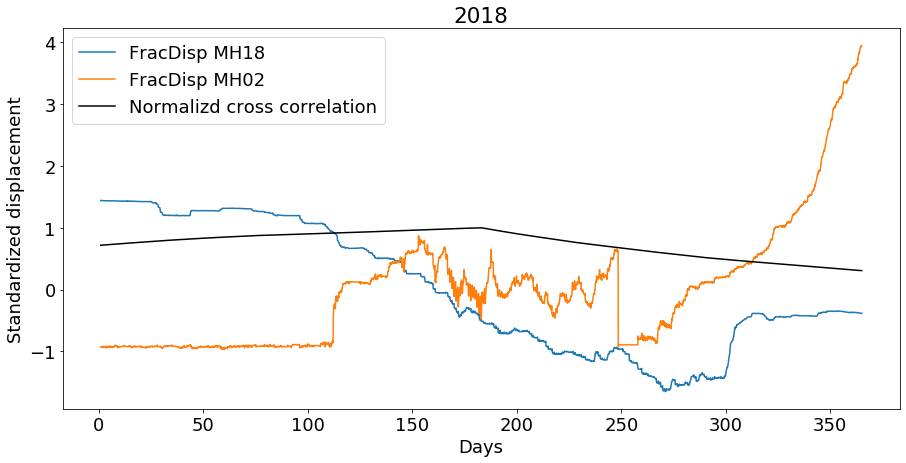

In [170]:
plt.figure(figsize=(15,7))
plt.rcParams.update({'font.size':18})
plt.plot(tim, zscore(df3.loc[:,'F18']))
plt.plot(tim, zscore(df3.loc[:,'F02_1']))
plt.plot(tim,xcorr,'-k')
#plt.fill_between()
plt.xlabel('Days')
plt.ylabel('Standardized displacement')
plt.legend(['FracDisp MH18','FracDisp MH02', 'Normalizd cross correlation'])
plt.title('2018')
#plt.savefig('/Users/gagan/Desktop/permafrost_data/frac_disp_MH18_02_2_1.jpg', dpi = 50, format='jpg')
#plt.close()

In [80]:
from scipy.signal import correlate, coherence

In [166]:
xcorr = correlate(df3['F18'], df3['F02_2'], mode='same')
xcorr = xcorr / np.max(np.abs(xcorr))

# SARIMAX

In [87]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [192]:
Ydata = (df3.loc[:,'F02_1'] - df3.loc[:,'F02_1'].mean()) / df3.loc[:,'F02_1'].std()
#Xdata = df2.loc[:,['F03','F04','F06','F18','F20','F21','T30_2','T30_5', 'T10_5','Tfrac07_4','Tfrac03_6','ResRock10_4']]
Xdata = df3.loc[:, ['F21_01', 'F21_02', 'F03_1','F04_1','F02_2','F18']]

In [193]:
Xdata = (Xdata - Xdata.mean()) / Xdata.std()

In [194]:
Xdata.shape

(8760, 6)

In [195]:
smx = SARIMAX(endog=Ydata, exog=Xdata, order=(1,0,1), seasonal_order=(0,0,0,0), simple_differencing=True)

In [196]:
results = smx.fit()

/Users/gagan/anaconda3/envs/permafrost/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


# temperature fracture

In [173]:
PA = os.listdir('/Users/gagan/Desktop/permafrost_data/timeseries_derived_data_products 2/')

In [174]:
frac_temp_fls = [f for f in PA if 'temperature_fracture' in f and '2018' in f]
frac_temp_fls

['MH04_temperature_fracture_2018.csv',
 'MH03_temperature_fracture_2018.csv',
 'MH05_temperature_fracture_2018.csv',
 'MH09_temperature_fracture_2018.csv',
 'MH07_temperature_fracture_2018.csv']

In [188]:
frac = pd.read_csv('/Users/gagan/Desktop/permafrost_data/timeseries_derived_data_products 2/MH03_temperature_fracture_2018.csv')

In [189]:
frac.isna().sum()

time                     0
position []              0
device_id []             0
temperature_10cm [°C]    0
temperature_40cm [°C]    0
temperature_60cm [°C]    0
temperature_70cm [°C]    0
temperature_75cm [°C]    0
temperature_80cm [°C]    0
temperature_85cm [°C]    0
ref1 [°C]                0
ref2 [°C]                0
ref4 [°C]                0
dtype: int64

In [190]:
frac.head(3)

,time,position [],device_id [],temperature_10cm [°C],temperature_40cm [°C],temperature_60cm [°C],temperature_70cm [°C],temperature_75cm [°C],temperature_80cm [°C],temperature_85cm [°C],ref1 [°C],ref2 [°C],ref4 [°C]
0,2018-01-01T00:00:00Z,3.0,2124.0,-9.5933,-9.1160,-9.2611,-8.7546,-9.2110,-8.2396,-8.5146,2.0473,-9.5818,2.0445
1,2018-01-01T01:00:00Z,3.0,2124.0,-9.9219,-9.4115,-9.7639,-8.9227,-9.6264,-8.3489,-8.5675,2.0467,-9.5826,2.0440
2,2018-01-01T02:00:00Z,3.0,2124.0,-9.8861,-9.4396,-9.7414,-8.9062,-9.5959,-8.4040,-8.5039,2.0470,-9.5825,2.0442


In [187]:
Tfrac04 = frac.iloc[:, 3:7]
Tfrac04.head(2)

,temperature_5cm [°C],temperature_20cm [°C],temperature_30cm [°C],temperature_35cm [°C]
0,-9.5783,-10.1262,-9.2995,-9.7552
1,-9.9718,-10.2574,-9.3480,-9.7349


In [191]:
Tfrac03 = frac.iloc[:, 3:10]
Tfrac03.head(2)

,temperature_10cm [°C],temperature_40cm [°C],temperature_60cm [°C],temperature_70cm [°C],temperature_75cm [°C],temperature_80cm [°C],temperature_85cm [°C]
0,-9.5933,-9.1160,-9.2611,-8.7546,-9.2110,-8.2396,-8.5146
1,-9.9219,-9.4115,-9.7639,-8.9227,-9.6264,-8.3489,-8.5675


# PCA

In [199]:
from sklearn.decomposition import PCA, FastICA

In [224]:
pca = PCA(n_components=0.97, whiten=True)
xpca = pca.fit_transform(np.array(df3))

In [225]:
xpca.shape

(8760, 3)

Text(0, 0.5, 'PCA Displacement components')

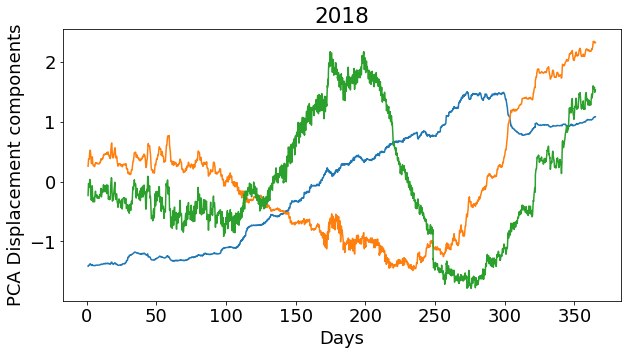

In [236]:
plt.figure(figsize=(10,5))
plt.plot(tim, xpca)
plt.xlabel('Days')
plt.title('2018')
plt.ylabel('PCA Displacement components')
#plt.savefig('/Users/gagan/Desktop/permafrost_data/pca_fracdisp2018.jpg', dpi=50, format ='jpg')
#plt.close()

In [229]:
C = pca.noise_variance_
C

0.009693544975719734

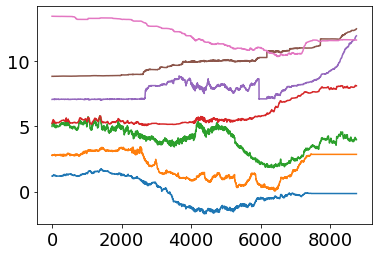

In [232]:
for i in range(df3.shape[-1]):
    plt.plot(zscore(df3.iloc[:,i]) + i*2)
plt.show()

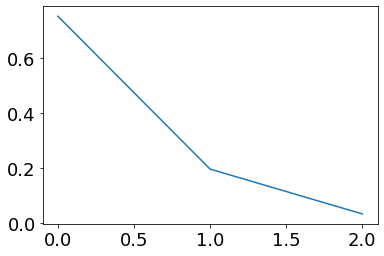

In [209]:
plt.plot(pca.explained_variance_ratio_)

In [211]:
help(pca)

Help on PCA in module sklearn.decomposition.pca object:

class PCA(sklearn.decomposition.base._BasePCA)
 |  PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
 |  
 |  Principal component analysis (PCA)
 |  
 |  Linear dimensionality reduction using Singular Value Decomposition of the
 |  data to project it to a lower dimensional space. The input data is centered
 |  but not scaled for each feature before applying the SVD.
 |  
 |  It uses the LAPACK implementation of the full SVD or a randomized truncated
 |  SVD by the method of Halko et al. 2009, depending on the shape of the input
 |  data and the number of components to extract.
 |  
 |  It can also use the scipy.sparse.linalg ARPACK implementation of the
 |  truncated SVD.
 |  
 |  Notice that this class does not support sparse input. See
 |  :class:`TruncatedSVD` for an alternative with sparse data.
 |  
 |  Read more in the :ref:`User Guide <PCA>`.
 |  
 |  Para